In [ ]:
# https://github.com/nateburley/WikiKnowledgeGraphs/tree/master

In [12]:
!pip install spacy
!pip install wikipedia-api
!pip install networkx
!pip install pandas
!pip install matplotlib

In [17]:
"""
This file mines Wikipedia articles for syntax and keywords, and builds a knowledge graph.

Author: Nathaniel M. Burley

Notes:
- Look at Word2Vec, and then embedding that "vector space" as a knowledge graph and
  preserve the relations somehow...

Sources:
    - https://towardsdatascience.com/auto-generated-knowledge-graphs-92ca99a81121
    - Really useful overview, with real-world examples and lots of pictures (for class paper):
        https://usc-isi-i2.github.io/slides/2018-02-aaai-tutorial-constructing-kgs.pdf

"""

# Wikipedia scraping libraries
from typing import List
from pandas.core.frame import DataFrame
import wikipediaapi  # pip install wikipedia-api
import pandas as pd
import concurrent.futures
from tqdm import tqdm
# NLP/Computational Linguistics libraries
import re
import spacy
#import neuralcoref
# Graph libraries
import networkx as nx
import matplotlib.pyplot as plt
# Miscellaneous
import pickle

# Establish Wikipedia API connection
wiki_api = wikipediaapi.Wikipedia('NateB_WikiKnowledgeGraph_Reproduction', language='en', extract_format=wikipediaapi.ExtractFormat.WIKI)

########################################################################################################################
## SCRAPE WIKIPEDIA REGARDING A TOPIC
########################################################################################################################

# Function that gets all unique links in an array of pages
def get_page_links(page_names: list) -> list:
    page_links = []
    for page_name in page_names:
        new_links = list(page_name.links.keys())
        page_links = list(set().union(page_links, new_links))

    print("\n\nLINKS: {}".format(page_links))
    return page_links


# Function that gets a page object for a link, or None
def get_link(link):
        try:
            page = wiki_api.page(link)
            if page.exists():
                return {'page': link, 'text': page.text, 'link': page.fullurl, 'categories': list(page.categories.keys())}
        except:
            return None


# Function that removes invalid pages from a list
# TODO: Annnotate what the lists take in the arguments
def remove_null_pages(page_names: list, topic_names: list) -> tuple[list, list]:

    # Iterate through the page names provided and check them against the API
    for page_name in page_names:
        index = page_names.index(page_name)

        # If the page doesn't exist, remove it from the lists
        if not page_name.exists():
            print(f'Page \'{topic_names[index]}\' does not exist')
            page_names.remove(page_name)
            topic_names.remove()

        # Display the page name
        else:
            print(f'Verified page \'{page_name}\'')

    # Return the updated topic names and pages
    return page_names, topic_names


# Function that scrapes all the pages in our list
# TODO: Annotate this
def scrape_all_pages(topics: list, pages: list, links: list, ) -> DataFrame:
    verbose = True

    progress = tqdm(desc='Links Scraped', unit='', total=len(links)) if verbose else None
    sources = [{'page': topic_name, 'text': page_name.text, 'link': page_name.fullurl, \
        'categories': list(page_name.categories.keys())} for topic_name, page_name in zip(topics, pages)]

    #print(f'\nDEBUG: length of sources: {len(sources)}')

    # Parallelize the scraping, to speed it up
    with concurrent.futures.ThreadPoolExecutor(max_workers=4) as executor:
        future_link = {executor.submit(get_link, link): link for link in links}
        for future in concurrent.futures.as_completed(future_link):
            data = future.result()
            sources.append(data) if data else None
            progress.update(1) if verbose else None
    progress.close() if verbose else None

    #print(f'\nDEBUG: length of sources: {len(sources)}')

    # Define namespaces (Wikipedia under the MediaWiki umbrella)
    namespaces = ('Wikipedia', 'Special', 'Talk', 'LyricWiki', 'File', 'MediaWiki', 'Template', 'Help', 'User', \
        'Category talk', 'Portal talk')
    sources = pd.DataFrame(sources)
    #print(f'\nDEBUG: sources: {sources}')
    sources = sources[(len(sources['text']) > 20) & ~(sources['page'].str.startswith(namespaces, na=True))]
    #print(f'\nDEBUG: sources: {sources}')
    sources['categories'] = sources.categories.apply(lambda x: [y[9:] for y in x])
    #sources['topic'] = topic_name # Seems redundant? Since 'page' is already set to topic_name?
    print('Wikipedia pages scraped:', len(sources))

    return sources


# Function that scrapes Wikipedia for a given topic
def wiki_scrape(topic_names, verbose=True):
    """
    Function that scrapes Wikipedia for text.
        - Takes in a list of topic names, i.e. page names
        - Scrapes text from:
            1) All the pages
            2) All the links in the pages
          Into a dataframe
        - Returns the dataframe
    Args:
        topic_names: List of strings. Titles of Wikipedia pages, ex. ['Miami Dolphins', 'World War II']
            Must be an exact match, otherwise no page will be returned.
    Outputs:
        sources: Pandas dataframe of
    """

    # Build a list of page objects, i.e. getting all the pages each topic name corresponds to
    page_names = [wiki_api.page(topic_name) for topic_name in topic_names]

    # Remove all NULL pages from the list (i.e. the topic doesn't match an actual Wikipedia page)
    page_names, topic_names = remove_null_pages(page_names=page_names, topic_names=topic_names)

    # Get links in all the pages
    page_links = get_page_links(page_names)

    # Scrape all the pages and links
    sources = scrape_all_pages(topics=topic_names, pages=page_names, links=page_links)

    return sources



########################################################################################################################
## COMPUTATIONAL LINGUISTICS/NLP FUNCTIONING
# This section contains functions that do dependency parsing and find subject-predicate-object dependencies
# TODO: Look into coreference resolution to remove redundancies, normalize, etc. [adds a neural net here]
"""
NOTES:
    - Sources for information extraction, and spacy:
        - https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/
        - https://www.analyticsvidhya.com/blog/2020/06/nlp-project-information-extraction/
        - https://www.analyticsvidhya.com/blog/2019/09/introduction-information-extraction-python-spacy/
        - https://realpython.com/natural-language-processing-spacy-python/
        - https://programmerbackpack.com/python-knowledge-graph-understanding-semantic-relationships/

    - Word2Vec similarity could be used to drop irrelevant terms
        - Overview of text embeddings: https://jalammar.github.io/illustrated-word2vec/
        - Train the algorithm on all the pages used and then drop terms with low co-occurences (?)
          That might only work for large datasets, but...could be worth looking into!

    - Honestly, I should probably re-write this from scratch using better logic and sentence structure
      for the relationship tuples. I can hand-code lots of simple rules, and maybe find libraries with more

    * Something else that could be an interesting side project, perhaps on its own: inferring semantic rules from similar
      dependency trees! The article (linked below) gives an introduction, but it would be interesting to put some thought
      into mathematically determining how similar given trees are...this could actually even involve some CBR:
        - Take some common trees (hyper/hyponyms, etc.) and make rules for them
        - Next, for a sentence that doesn't fit into a pre-defined rule, figure out the most similar dependency tree, and
          modify the rule as needed to fit the new sentence!
        - That rule then goes into our list of rules, and the iteration proceeds
      This could be a frickin' paper. "Automatic Semantic Rule Inference Using Case Based Reasoning"
    - On that note, here's an algorithm for comparing trees: https://arxiv.org/pdf/1508.03381.pdf
"""
########################################################################################################################

nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web_lg')
#neuralcoref.add_to_pipe(nlp)

# spacy.util.filter_spans
def filter_spans(spans):
    # Filter a sequence of spans so they don't contain overlaps
    # For spaCy 2.1.4+: this function is available as spacy.util.filter_spans()
    get_sort_key = lambda span: (span.end - span.start, -span.start)
    sorted_spans = sorted(spans, key=get_sort_key, reverse=True)
    result = []
    seen_tokens = set()
    for span in sorted_spans:
        # Check for end - 1 here because boundaries are inclusive
        if span.start not in seen_tokens and span.end - 1 not in seen_tokens:
            result.append(span)
        seen_tokens.update(range(span.start, span.end))
    result = sorted(result, key=lambda span: span.start)
    return result

# Function that gets pairs of subjects and relationships
def get_entity_pairs(text, coref=True):
    # preprocess text
    text = re.sub(r'\n+', '.', text)  # replace multiple newlines with period
    text = re.sub(r'\[\d+\]', ' ', text)  # remove reference numbers
    text = nlp(text)

    # TEMP DISABLED
    #if coref:
        #text = nlp(text._.coref_resolved)  # resolve coreference clusters

    def refine_entities(ent, sent):
        unwanted_tokens = (
            'PRON',  # pronouns
            'PART',  # particle
            'DET',  # determiner
            'SCONJ',  # subordinating conjunction
            'PUNCT',  # punctuation
            'SYM',  # symbol
            'X',  # other
        )
        ent_type = ent.ent_type_  # get entity type
        if ent_type == '':
            ent_type = 'NOUN_CHUNK'
            ent = ' '.join(str(t.text) for t in nlp(str(ent)) if t.pos_ not in unwanted_tokens and t.is_stop == False)

        elif ent_type in ('NOMINAL', 'CARDINAL', 'ORDINAL') and str(ent).find(' ') == -1:
            refined = ''
            for i in range(len(sent) - ent.i):
                if ent.nbor(i).pos_ not in ('VERB', 'PUNCT'):
                    refined += ' ' + str(ent.nbor(i))
                else:
                    ent = refined.strip()
                    break

        return ent, ent_type

    # TEMP DISABLED
    #sentences = [sent.string.strip() for sent in text.sents]  # split text into sentences
    sentences = [(span[span.start:span.end]).text.strip() for span in text.sents]   # split text into sentences
    ent_pairs = []
    for sent in sentences:
        sent = nlp(sent)
        spans = list(sent.ents) + list(sent.noun_chunks)  # collect nodes
        spans = filter_spans(spans)
        with sent.retokenize() as retokenizer:
            [retokenizer.merge(span, attrs={'tag': span.root.tag, 'dep': span.root.dep}) for span in spans]
        deps = [token.dep_ for token in sent]

        # limit our example to simple sentences with one subject and object
        # if (deps.count('obj') + deps.count('dobj')) != 1 or (deps.count('subj') + deps.count('nsubj')) != 1:
            # continue

        for token in sent:
            if token.dep_ not in ('obj', 'dobj'):  # identify object nodes
                continue
            subject = [w for w in token.head.lefts if w.dep_ in ('subj', 'nsubj')]  # identify subject nodes
            if subject:
                subject = subject[0]
                # identify relationship by root dependency
                relation = [w for w in token.ancestors if w.dep_ == 'ROOT']
                if relation:
                    relation = relation[0]
                    # add adposition or particle to relationship
                    try:
                        if relation.nbor(1).pos_ in ('ADP', 'PART'):
                            relation = ' '.join((str(relation), str(relation.nbor(1))))
                    except:
                        print("Failed at line 207")
                        return
                else:
                    relation = 'unknown'

                subject, subject_type = refine_entities(subject, sent)
                token, object_type = refine_entities(token, sent)

                ent_pairs.append([str(subject), str(relation), str(token), str(subject_type), str(object_type)])

    ent_pairs = [sublist for sublist in ent_pairs if not any(str(ent) == '' for ent in sublist)]
    pairs = pd.DataFrame(ent_pairs, columns=['subject', 'relation', 'object', 'subject_type', 'object_type'])
    #print('Entity pairs extracted:', str(len(ent_pairs)))

    return pairs

# Function that extracts ALL the pairs. Not just the first one smh
def extract_all_relations(wiki_data):
    all_pairs = []
    for i in range(0, 100):
        pairs = get_entity_pairs(wiki_data.loc[i,'text'])
        all_pairs.append(pairs)
        print("Made it through {} iterations".format(i))
    all_pairs_df = pd.concat(all_pairs)
    print("Successfully extracted {} entity pairs".format(len(all_pairs_df.index)))
    return all_pairs_df



########################################################################################################################
## FUNCTION THAT DRAWS, PLOTS THE KNOWLEDGE GRAPH
########################################################################################################################

# Function that plots and draws a knowledge graph
def draw_KG(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object', create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.15, iterations=20)
    plt.figure(num=None, figsize=(120, 90), dpi=80)
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 1000 for deg in node_deg],
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='green',
        )
    labels = dict(zip(list(zip(pairs.subject, pairs.object)), pairs['relation'].tolist()))
    print(labels)
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels, font_color='black')
    plt.axis('off')
    plt.show()
    plt.savefig('church_knowledge_graph.png')


# Function that plots a "subgraph", if the main graph is too messy
# Example use: filter_graph(pairs, 'Directed graphs')
def filter_graph(pairs, node):
    k_graph = nx.from_pandas_edgelist(pairs, 'subject', 'object', create_using=nx.MultiDiGraph())
    edges = nx.dfs_successors(k_graph, node)
    nodes = []
    for k, v in edges.items():
        nodes.extend([k])
        nodes.extend(v)
    subgraph = k_graph.subgraph(nodes)
    layout = (nx.random_layout(k_graph))
    nx.draw_networkx(
        subgraph,
        node_size=1000,
        arrowsize=20,
        linewidths=1.5,
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white'
        )
    labels = dict(zip((list(zip(pairs.subject, pairs.object))), pairs['relation'].tolist()))
    edges= tuple(subgraph.out_edges(data=False))
    sublabels ={k: labels[k] for k in edges}
    nx.draw_networkx_edge_labels(subgraph, pos=layout, edge_labels=sublabels, font_color='red')
    plt.axis('off')
    plt.show()
    plt.savefig('church_knowledge_graph.png')

Made it through 0 iterations
Made it through 1 iterations
Made it through 2 iterations
Made it through 3 iterations
Made it through 4 iterations
Made it through 5 iterations
Made it through 6 iterations
Made it through 7 iterations
Made it through 8 iterations
Made it through 9 iterations
Made it through 10 iterations
Made it through 11 iterations
Made it through 12 iterations
Made it through 13 iterations
Made it through 14 iterations
Made it through 15 iterations
Made it through 16 iterations
Made it through 17 iterations
Made it through 18 iterations
Made it through 19 iterations
Made it through 20 iterations
Made it through 21 iterations
Made it through 22 iterations
Made it through 23 iterations
Made it through 24 iterations
Made it through 25 iterations
Made it through 26 iterations
Made it through 27 iterations
Made it through 28 iterations
Made it through 29 iterations
Made it through 30 iterations
Made it through 31 iterations
Made it through 32 iterations
Made it through 33 i

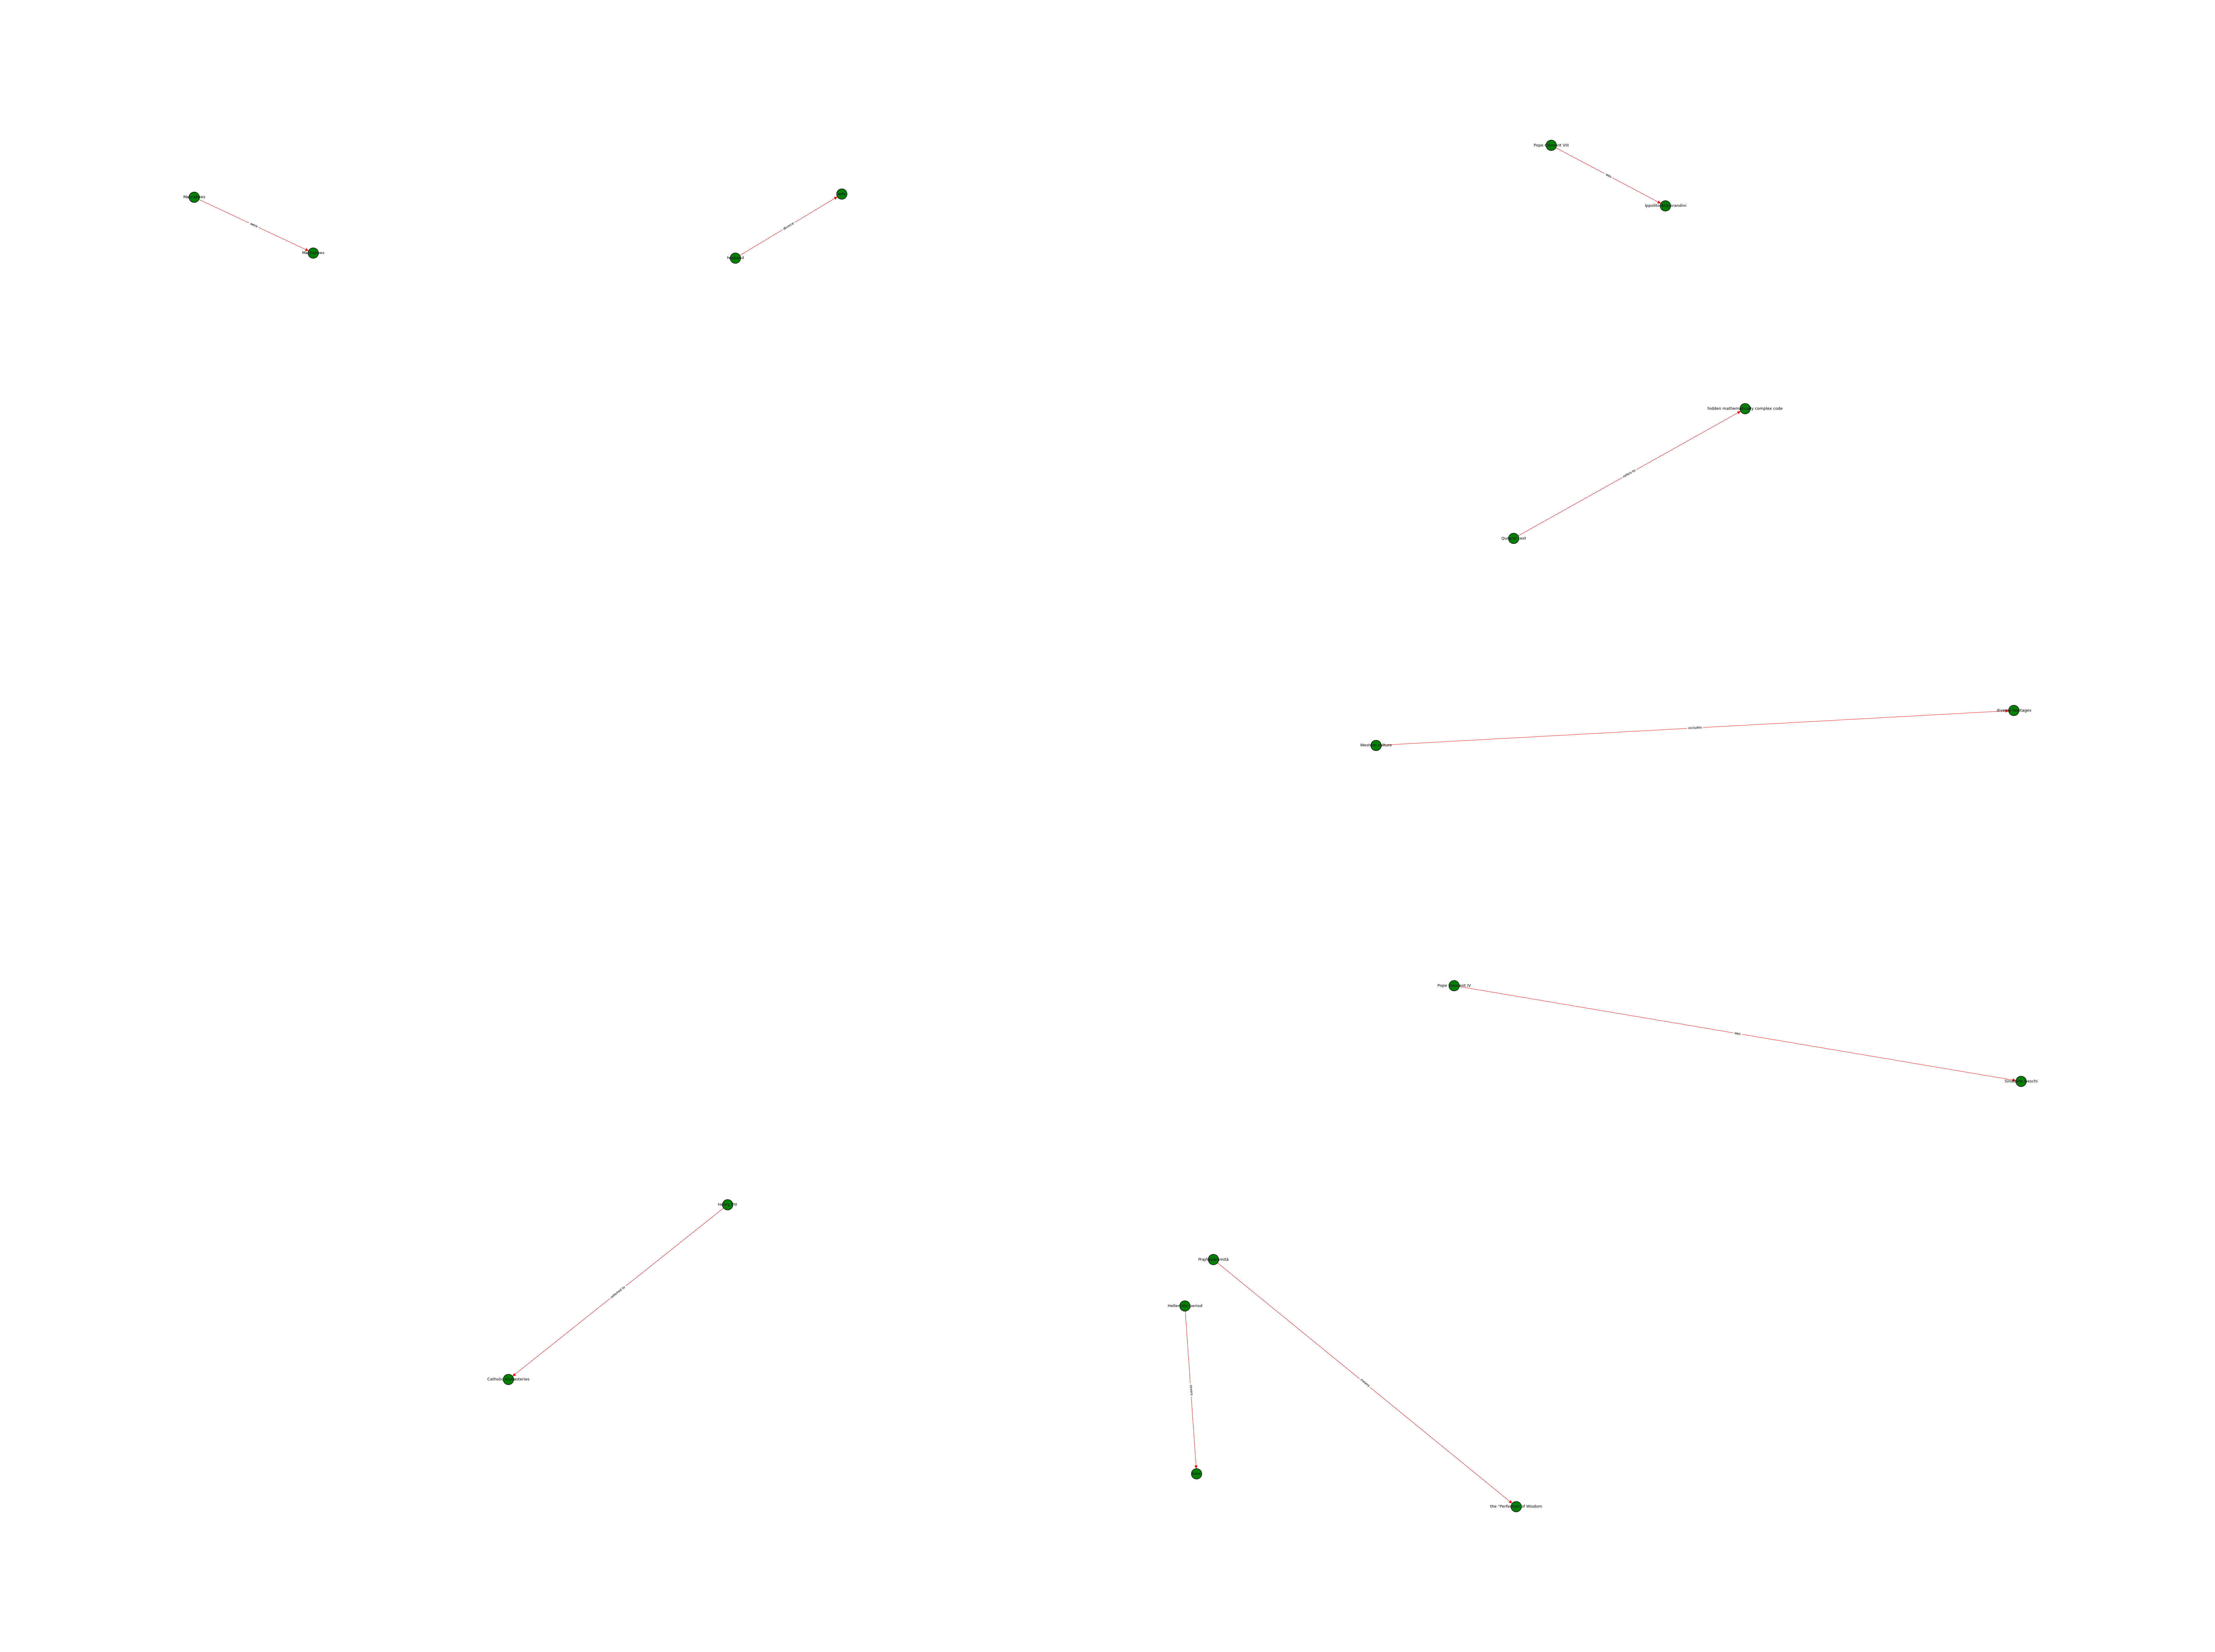

<Figure size 640x480 with 0 Axes>

In [18]:
# Scrape Wikipedia for a topic
'''
wiki_data = wiki_scrape(['Catholic Church', 'Islam', 'Russian Orthodox Church', 'Judaism', 'Buddhism', 'Panpsychism', 'UFO religion'])
print("WIKIPEDIA SCRAPE DF LENGTH: {}".format(len(wiki_data.index)))
print(wiki_data.head(25))
print("\n")
wiki_data.to_csv('/content/wiki_data.csv', index=False)

'''
# Load in the wiki data, so we don't have to scrape
wiki_data = pd.read_csv('/content/wiki_data.csv')

# Get subject object relationships (which form vertices and edges in the graph)
# TODO: Parallelize (thread) the shit out of this
#   - https://realpython.com/intro-to-python-threading/
all_pairs = extract_all_relations(wiki_data)
print("ENTITY PAIRS-- SUBJECT/OBJECT RELATIONSHIPS LENGTH: {}".format(len(all_pairs.index)))
print(all_pairs.head(20))
print(all_pairs.tail(20))
print("\n")

# Draw the graph
draw_KG(all_pairs)


In [6]:
df_verify = pd.read_csv('/content/wiki_data.csv')
print(df_verify)

                               page  \
0                   Catholic Church   
1                             Islam   
2           Russian Orthodox Church   
3                           Judaism   
4                          Buddhism   
...                             ...   
7342                Erich Klausener   
7343  Category:Philosophers of mind   
7344         Unity of consciousness   
7345                      Yazdânism   
7346              Thracian religion   

                                                   text  \
0     The Catholic Church, also known as the Roman C...   
1     Islam ( IZ-la(h)m; Arabic: ٱلْإِسْلَام, romani...   
2     The Russian Orthodox Church (ROC; Russian: Рус...   
3     Judaism (Hebrew: יַהֲדוּת‎, romanized: Yahăḏūṯ...   
4     Buddhism ( BUUD-ih-zəm, US also  BOOD-), also ...   
...                                                 ...   
7342  Erich Klausener (25 January 1885 – 30 June 193...   
7343  Philosophers in the philosophy of mind. \nSee ...   
